In [1]:
import sys

sys.path.append("/home/users/arustam/fwix/operator/lib/python/")
sys.path.append("/home/users/arustam/fwix/propagator/lib/python/")

In [2]:
%load_ext autoreload
%autoreload 2
import SepVector
import CudaOperator
# import CudaWEM
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt


/usr/local/lib/python3.10/dist-packages/numpy/_core/getlimits.py:555: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.10/dist-packages/numpy/_core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.10/dist-packages/numpy/_core/getlimits.py:555: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.10/dist-packages/numpy/_core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [3]:
ns = [1000,1000,10,10]
ds = [0.01, 0.01, 0.1, 1]
os = [0,   0,   0.1,   0]

vec = SepVector.getSepVector(ns=ns, ds=ds, os=os, storage='dataComplex')

In [4]:
vec[:, :, 250, 250] = 1
fft = vec.clone()

sig = 3
vec[:] = gaussian_filter(vec[:], sigma=(1,1,sig,sig))

In [5]:
orig = vec.clone()

In [6]:
vec.getHyper().cppMode

In [7]:
cufft = CudaOperator.cuFFT2d(vec, vec)

In [9]:
fft.zero()

complexVector
Axis 1: n=500	o=0.000000	d=0.010000
Axis 2: n=500	o=0.000000	d=0.010000
Axis 3: n=10	o=0.100000	d=0.100000
Axis 4: n=10	o=0.000000	d=1.000000

In [10]:
cufft.forward(False, vec, fft)
# cufft.adjoint(False, orig, fft)

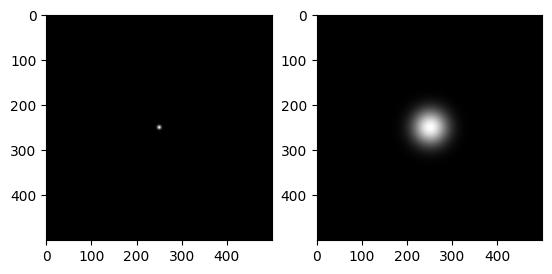

In [11]:

f, a = plt.subplots(1,2)
a[0].imshow(vec[5,5,:,:].real, cmap='gray')
a[1].imshow(np.fft.fftshift(np.abs(fft[5,5,:,:])), cmap='gray')

In [12]:
np.amax(fft[:])

np.complex64(0.002+0j)

In [13]:
(vec-orig).norm()

0.0

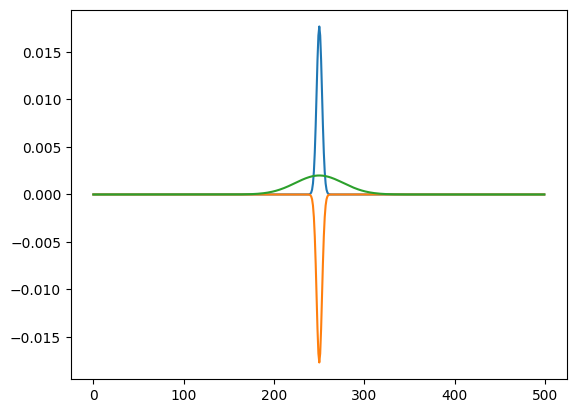

In [16]:
plt.plot(vec[5,5,250,:])
plt.plot(orig[5,5,250,:])
plt.plot(np.fft.fftshift(np.abs(fft[5,5,:,:]))[250,:])

In [ ]:
ps = CudaWEM.PhaseShift(vec, vec, ds[1], 0.)
slow = np.ones(10, dtype=np.complex64) * (0.001**2)
ps.set_slow(slow)

In [ ]:
out = fft.clone()
for _ in range(100):
    ps.forward(False, out, vec)
    out = vec.clone()

In [ ]:
fwd = out.clone()
cufft.adjoint(False, fwd, vec)

In [ ]:
f, a = plt.subplots(1,2)
a[0].imshow(orig[5,5,:,:].real, cmap='gray')
a[1].imshow(fwd[5,5,:,:].real, cmap='gray')
plt.show()

In [ ]:
for _ in range(50):
    ps.adjoint(False, out, vec)
    vec = out.clone()

In [ ]:
adj = out.clone()
cufft.adjoint(False, adj, out)

In [ ]:
f, a = plt.subplots(1,3,figsize=[20,20])
a[0].imshow(orig[5,5,:,:].real, cmap='gray')
a[1].imshow(fwd[5,5,:,:].real, cmap='gray')
a[2].imshow(adj[5,5,:,:].real, cmap='gray')
plt.show()

In [ ]:
ps.dotTest(verbose=True)